## Section 2.6 – Exercise 2.6
The case of the Mysterious Spikes

Explain the pattern observed with optimistic priors on the 10-armed bandit problem. See Sutton and Barto for context and notation (e.g. q_star, epsilon_greediness, etc)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import norm, uniform, randint
from tensorflow.keras.utils import Progbar as ProgressBar

import seaborn as sns
import matplotlib.pyplot as plt
plt.ioff()
sns.set()

In [2]:
class SlotMachine:
  
  def __init__(self):
    self.q_star = norm.rvs(0, 1) # mean/variance
    self.reward = norm(self.q_star, 1)
    
  def play(self):
    return self.reward.rvs()

In [3]:
class Casino:
  
  def __init__(self, num_machines):
    self.k        = num_machines
    self.reset()
    
  def reset(self):
    self.machines = [SlotMachine() for _ in range(self.k)]
    self.q_stars  = np.array([machine.q_star for machine in self.machines])
    self.optimal_machine = self.q_stars.argmax()
    
  def __getitem__(self,index):
    return self.machines[index]
  
  def __len__(self):
    return self.k
  
  def play(self, index):
    return self.machines[index].play()


In [15]:
class Bandit:
  
  def __init__(self, casino, epsilon_greediness, lr = lambda n, t : 1/n, priors = None):
    self.priors = priors
    self.epsilon = epsilon_greediness
    self._lr     = lr
    self.reset(casino)

  def reset(self, casino):
    if self.priors is None:
      self.q_star_estimates  = [0.0] * len(casino)
    else:
      self.q_star_estimates  = self.priors.copy()
      
    self.casino = casino
    self.q_star_estimates = np.array(self.q_star_estimates)
    self.t       = 0
    self.num_times_played = [0] * len(casino)
    self.rewards = []
    self._rand_machine = randint(0, len(casino))

    
  def lr(self, machine):
    n = self.num_times_played[machine] + 1
    t = self.t
    return self._lr(n, t)
    
  def rand_machine(self):
    return self._rand_machine.rvs()
    
  def choose_machine(self):
    if uniform.rvs() < self.epsilon:
      machine = self.rand_machine()
    else:
      machine = self.q_star_estimates.argmax()
      
    return machine
      
  def play_machine(self, machine = None):
    if machine is None:
      machine = self.choose_machine()
      
    reward = casino.play(machine)
    self.rewards.append(reward)
    
    lr = self.lr(machine)
    
    self.num_times_played[machine] += 1
    self.t += 1
    
    q_n = self.q_star_estimates[machine]
    self.q_star_estimates[machine] = q_n + lr * (reward - q_n)
    
    return machine, reward

In [8]:
class Simulator:
  
  def __init__(self, bandits, casino, time = 1000, num_runs = 2000, burn_in = False):
    self.time     = time
    self.num_runs = num_runs
    self.burn_in  = burn_in
    self.bandits      = []
    self.bandit_names = []
    for bandit_name, bandit in bandits.items():
      self.bandit_names.append(bandit_name)
      self.bandits.append(bandit)
    
    self.casino   = casino
    
    self.optimal_machine = [[] for _ in range(len(self.bandits))]
    self.rewards         = [[] for _ in range(len(self.bandits))]
    
  def run_bandit(self, bandit_index):
    
    optimal_machine = []
    rewards         = []
    bandit          = self.bandits[bandit_index]
          
    for t in range(self.time):
      if self.burn_in and t < len(casino):
        machine, reward = bandit.play_machine(machine = t)
      else:
        machine, reward = bandit.play_machine()
        
      rewards.append(reward)
      optimal_machine.append(machine == casino.optimal_machine)
    
    self.optimal_machine[bandit_index].append(optimal_machine)
    self.rewards[bandit_index].append(rewards)
    
  def run_bandits(self):
    for bandit_index in range(len(self.bandits)):
      self.run_bandit(bandit_index)
      
  def run(self):
    bar = ProgressBar(self.num_runs)
    for _ in range(self.num_runs):
      self.casino.reset()
      for bandit in self.bandits:
        bandit.reset(casino)
      self.run_bandits()
      bar.add(1)
      
    return self
  
  def plot(self, dv = 'reward'):
    if dv not in ['reward', 'optimality']:
      return ValueError('Choose reward or optimality')
    
    if dv == 'reward':
      data = self.rewards
    elif dv == 'optimality':
      data = self.optimal_machine
      
    data = np.array(data)
    data = data.mean(axis = 1)
    
    df = pd.DataFrame(data.T, columns = self.bandit_names, index = pd.RangeIndex(1, self.time+1, name = 'time'))
    self.df = df
    df = df.reset_index()
    df = df.melt(id_vars = 'time', var_name = 'strategy', value_name = dv)
    
    
    fig, ax = plt.subplots()
    sns.lineplot(x = 'time', y = dv, hue = 'strategy', data = df, ax = ax)
    ax.set_title(dv)
    return fig
  
  def plots(self):
    sim.plot('reward')
    sim.plot('optimality')
    plt.show()

2000/2000 [==============================] - 758s 379ms/step


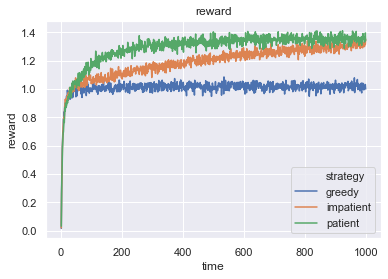

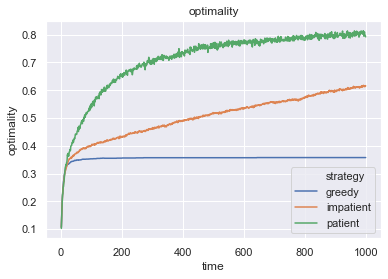

In [13]:
casino = Casino(10)
bandits = {
  'greedy'    : Bandit(casino, 0),
  'impatient' : Bandit(casino, 0.01),
  'patient'   : Bandit(casino, 0.1)
}

# Figure 2.2 (page 29)
sim = Simulator(bandits, casino, num_runs = 2000).run()
sim.plots()

### Optimistic Prior

2000/2000 [==============================] - 486s 243ms/step


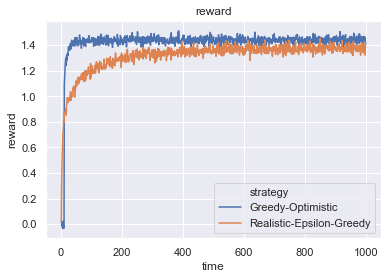

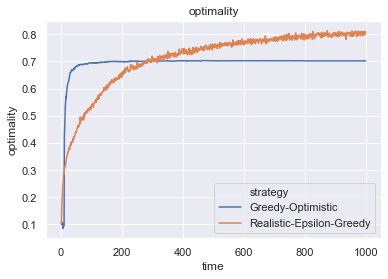

In [19]:
casino = Casino(10)
prior  = [5.0] * 10
bandits = {
  'Greedy-Optimistic'          : Bandit(casino, 0   , priors = prior),
  'Realistic-Epsilon-Greedy'   : Bandit(casino, 0.1)
}

# Figure 2.3 (page 35)
sim = Simulator(bandits, casino, num_runs = 2000).run()
sim.plots()